In [22]:
import sys
sys.path.insert(0, '../')
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import torch
from matplotlib.patches import Patch
from utils.data_utils import BratsDataset3D
from utils.predict import ModelPredict

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = r'C:\Users\johns\OneDrive\Desktop\Models\ECE542_Project_Brain_Segmentation\20K_model_10_epochs.pth'
model = torch.load(model_path)

In [24]:
scan_dir = r'C:\Users\johns\OneDrive\Desktop\Datasets\ECE-542\brain-tumor-segmentation(nii)\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData'
scan_index = 0
dataset = BratsDataset3D(scan_dir)

In [27]:
[input_tensor, label_tensor] = dataset.__getitem__(scan_index)

# Move input to GPU
input_tensor = input_tensor.to(device)

In [31]:
if next(model.parameters()).is_cuda:
    print("Model on GPU")
else:
    print("Model on CPU")

if input_tensor.is_cuda:
    print("Tensor is on GPU")
else:
    print("Tensor is on CPU")
# Fixing tensor shape
input_tensor = torch.unsqueeze(input_tensor, 0)
print(f'Tensor shape is: {input_tensor.shape}')

Model on GPU
Tensor is on GPU
Tensor shape is: torch.Size([1, 4, 240, 240, 155])


In [33]:
model_output = model(input_tensor)
print(max(model_output))

tensor([[[[-3.4985, -3.3295, -3.3004,  ..., -3.2488, -3.3095, -3.4526],
          [-3.3844, -3.1301, -3.1218,  ..., -3.0127, -3.0795, -3.3288],
          [-3.3633, -3.1167, -3.0879,  ..., -2.9626, -3.0626, -3.3105],
          ...,
          [-3.4125, -3.1516, -3.1413,  ..., -3.0008, -3.0710, -3.3179],
          [-3.3935, -3.1465, -3.1224,  ..., -3.0183, -3.0819, -3.3330],
          [-3.5526, -3.3983, -3.3750,  ..., -3.3126, -3.3560, -3.4995]],

         [[-3.4903, -3.2763, -3.2986,  ..., -3.2228, -3.2592, -3.4072],
          [-3.3700, -3.1075, -3.0908,  ..., -2.9501, -3.0132, -3.2567],
          [-3.3588, -3.0687, -3.0523,  ..., -2.8801, -2.9848, -3.2285],
          ...,
          [-3.3930, -3.1149, -3.1251,  ..., -2.9181, -2.9825, -3.2455],
          [-3.3737, -3.0892, -3.0617,  ..., -2.9065, -2.9931, -3.2343],
          [-3.5464, -3.3589, -3.3756,  ..., -3.2731, -3.2917, -3.4789]],

         [[-3.4683, -3.3074, -3.2906,  ..., -3.2200, -3.2728, -3.4153],
          [-3.3805, -3.0825, -

In [ ]:
scan_np  = input_tensor.squeeze.numpy()
pred_np  = model_output.squeeze().numpy()  
label_np = label_tensor.squeeze().numpy()  

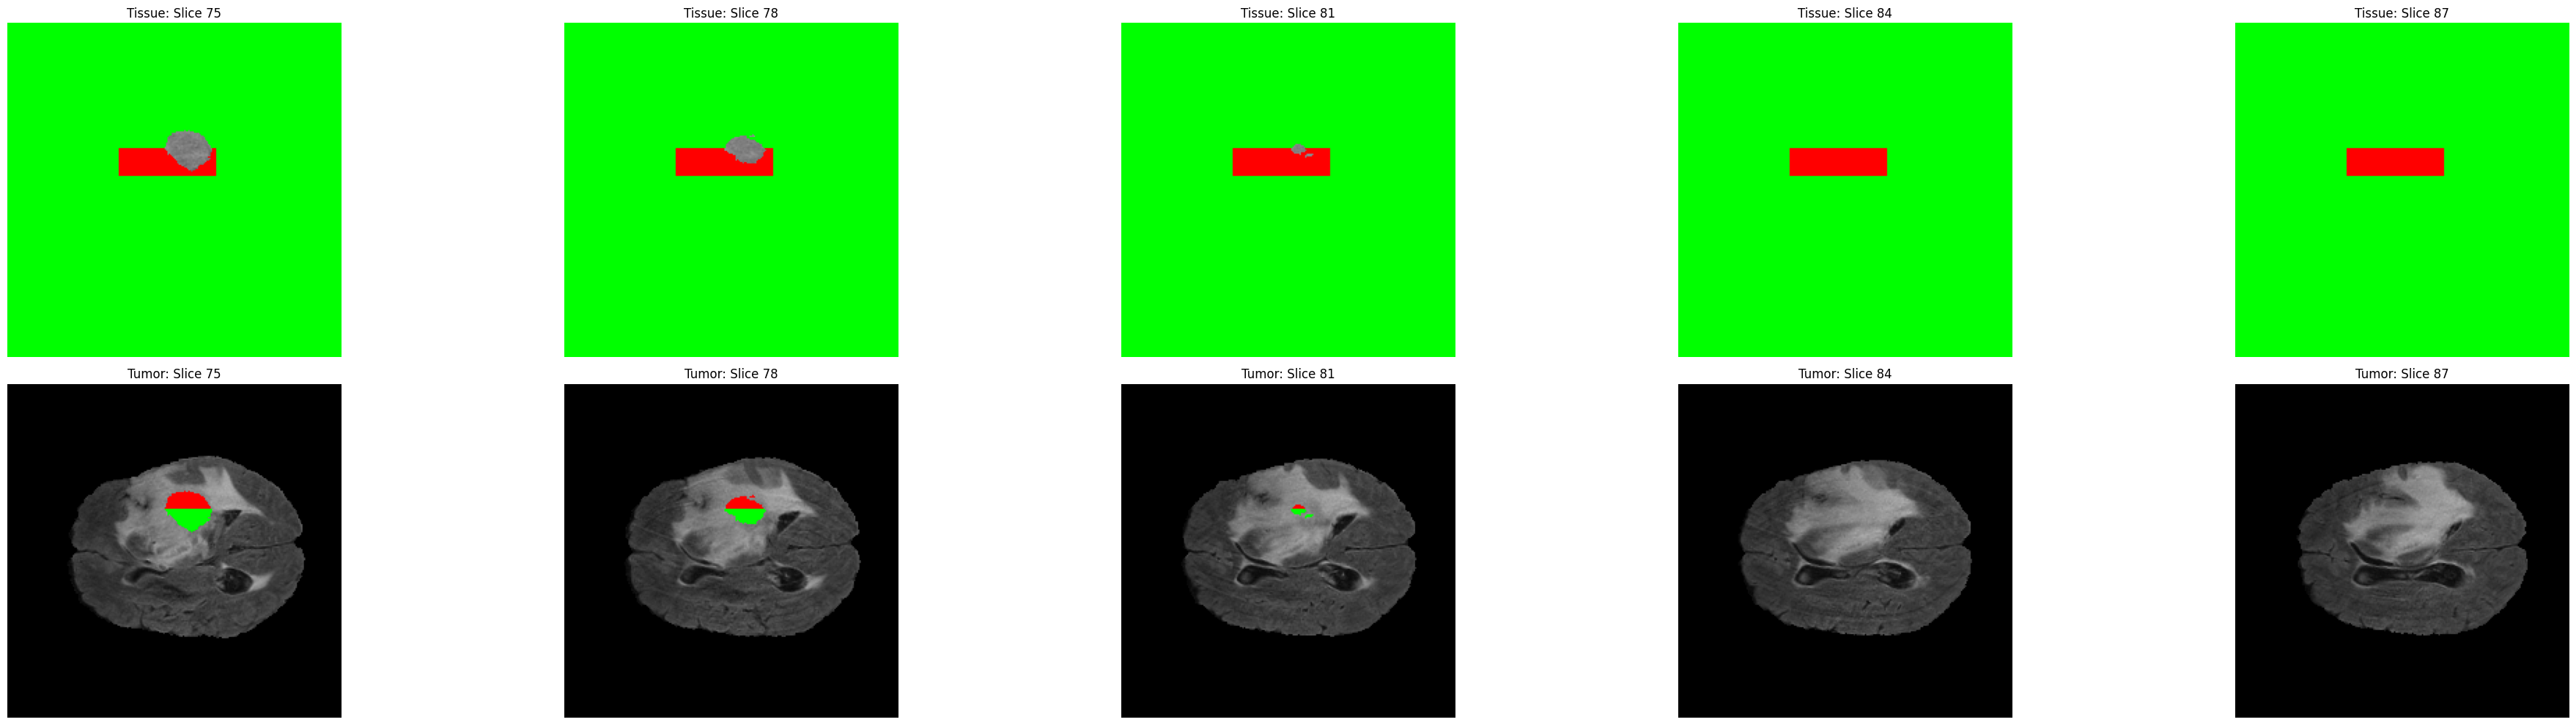

In [6]:
num_slices = 5
middle_slice = 75  # Adjust as needed
num_rows = 1
num_cols = num_slices

tissue_class_value = 0 
tumor_class_value = 1

plt.figure(figsize=(20, 5))

for i in range(num_slices):
    current_slice = middle_slice + 3 * i
    scan_slice = scan_np[:, :, current_slice]
    pred_slice = pred_np[:, :, current_slice]
    truth_slice = label_np[:, :, current_slice]

    correct_tissue = (pred_slice == truth_slice) & (truth_slice == tissue_class_value)
    incorrect_tissue = (pred_slice != truth_slice) & (truth_slice == tissue_class_value)

    correct_tumor = (pred_slice == truth_slice) & (truth_slice == tumor_class_value)
    incorrect_tumor = (pred_slice != truth_slice) & (truth_slice == tumor_class_value)

    overlay_tissue = dataset.create_overlay(scan_slice, correct_tissue, incorrect_tissue)
    overlay_tumor = dataset.create_overlay(scan_slice, correct_tumor, incorrect_tumor)

    plt.subplot(2, num_slices, i + 1)
    plt.imshow(overlay_tissue)
    plt.title(f'Tissue: Slice {current_slice}')
    plt.axis('off')
    
    # Plot tumor overlay
    plt.subplot(2, num_slices, num_slices + i + 1)
    plt.imshow(overlay_tumor)
    plt.title(f'Tumor: Slice {current_slice}')
    plt.axis('off')


plt.tight_layout()
plt.show()